In [1]:
import pathlib
from glob import glob
from keras.preprocessing import image

In [ ]:
!ls -l ./img

total 24
drwxr-xr-x 2 lab11 multi 12288 Apr 16 15:53 0
drwxr-xr-x 2 lab11 multi 12288 Apr 16 15:53 1


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/img_adj.zip'

-rw------- 1 root root 51834876 Apr 16 08:12 '/content/drive/My Drive/Colab Notebooks/datasets/img_adj.zip'


In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/img_adj.zip

In [6]:
!ls -l img_adj/img

total 24
drwxr-xr-x 2 root root 12288 Apr 16 16:30 0
drwxr-xr-x 2 root root 12288 Apr 16 17:11 1


In [8]:
from tensorflow.keras.applications import ResNet50

conv_base =  ResNet50(weights='imagenet', include_top=False, input_shape =(640,640,3))

set_trainable = False

for layer in conv_base.layers:
    if layer.name =='conv5_block2_1_conv' :      
        set_trainable = True

    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 646, 646, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 320, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 320, 320, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [10]:
from keras import layers, models, optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.MaxPooling2D((3,3)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.000005), metrics=['accuracy'])    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 20, 20, 2048)      23587712  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 42,462,593
Trainable params: 27,806,209
Non-trainable params: 14,656,384
_________________________________

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# image directory
image_dir = './img_adj/img'

random_seed = 414

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.3)

train_generator = datagen.flow_from_directory(image_dir,target_size = (640, 640), seed=random_seed,
                                                    batch_size = 60, class_mode = 'binary', subset='training')
valid_generator = datagen.flow_from_directory(image_dir, target_size=(640, 640), seed=random_seed,
                                              batch_size=40, class_mode='binary', subset='validation')


Found 382 images belonging to 2 classes.
Found 163 images belonging to 2 classes.


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
session = InteractiveSession(config = config)

In [14]:
%%time

Hist = model.fit(train_generator, steps_per_epoch=382//60,
                epochs=100, validation_data=valid_generator, validation_steps=163//40) 

Epoch 1/100
6/6 [==============================] - 15s 3s/step - loss: 0.0244 - accuracy: 0.9969 - val_loss: 0.7140 - val_accuracy: 0.5813
Epoch 2/100
6/6 [==============================] - 16s 3s/step - loss: 0.0245 - accuracy: 0.9972 - val_loss: 0.6954 - val_accuracy: 0.5875
Epoch 3/100
6/6 [==============================] - 15s 3s/step - loss: 0.0196 - accuracy: 0.9969 - val_loss: 0.7066 - val_accuracy: 0.5875
Epoch 4/100
6/6 [==============================] - 15s 3s/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.7248 - val_accuracy: 0.6000
Epoch 5/100
6/6 [==============================] - 15s 2s/step - loss: 0.0206 - accuracy: 0.9969 - val_loss: 0.7345 - val_accuracy: 0.5875
Epoch 6/100
6/6 [==============================] - 16s 3s/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.7772 - val_accuracy: 0.6000
Epoch 7/100
6/6 [==============================] - 15s 3s/step - loss: 0.0236 - accuracy: 1.0000 - val_loss: 0.7039 - val_accuracy: 0.6125
Epoch 8/100
6/6 [==========

In [15]:
loss, accuracy = model.evaluate(valid_generator, steps=5)
loss, accuracy

5/5 [==============================] - 4s 750ms/step - loss: 0.6501 - accuracy: 0.8098


(0.6501407623291016, 0.8098159432411194)

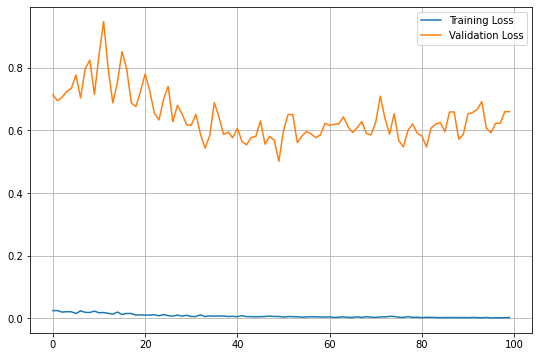

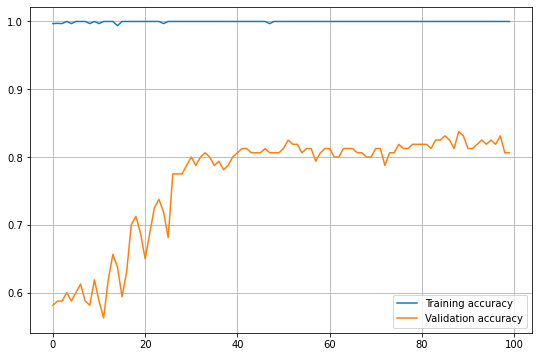

In [16]:
import matplotlib.pyplot as plt


plt.figure(figsize = (9, 6))
plt.plot( Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()


plt.figure(figsize = (9, 6))
plt.plot(Hist.history['accuracy'])
plt.plot( Hist.history['val_accuracy'])

plt.legend(['Training accuracy', 'Validation accuracy'])
plt.grid()
plt.show()